In [150]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random
import graphviz
import scipy
from sklearn.utils import check_random_state
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sympy import *
from IPython.display import display, Math
import os
pd.set_option('display.max_columns', None)
from datetime import datetime
import json

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'exp': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}


def multiclass_to_binary(labels, select_id):
    """Converts multiclass labels to select_id vs all
    """
    to_binary = lambda val: 1 if val == select_id else 0
    to_binary_vec = np.vectorize(to_binary)
    labels_1vsall = to_binary_vec(labels)
    return labels_1vsall


def vis_expr(classifier, save_prefix):
    """Function for prettifying expressions output by the symbolic classifier (denoted as SR_Classifier)
    Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas
    """
    expression = latex(sympify((str(SR_classifier._program)), locals=converter))
    fig, ax = plt.subplots(figsize=(0.1,0.1))
    ax.set_xticks([]); ax.set_yticks([])
    ax.axis('off')
    plt.text(0, 0,'$%s$'%expression, size=15)
    plt.savefig(f'{save_prefix}_expression.png', dpi=300, bbox_inches='tight')
    plt.show()


def save_model(classifier, save_prefix):
    formula = str(SR_classifier._program)
    params = SR_classifier.get_params()
    params['feature_names'] = list(params['feature_names'])
    params['function_set'] = list(params['function_set'])
    with open(f'{save_prefix}_params.json', 'a+') as f:
        json.dump(params, f)
    with open(f'{save_prefix}_formula.txt', 'a+') as f:
        f.write(formula)

        
def plot_run(classifier):
    run_details = classifier.run_details_
    fig, ax1 = plt.subplots(figsize=(6,2))
    skip_gen = 1
    colors = ['tab:red', 'tab:blue']
    ax1.set_ylabel('average_length', color=colors[0])
    ax1.plot(run_details['generation'][skip_gen:], run_details['average_length'][skip_gen:], 
             label='Avg Length', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
#     ax1.set_ylim(0,10)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('average_fitness', color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(run_details['generation'][skip_gen:], run_details['average_fitness'][skip_gen:], 
             label='Avg Length', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
#     ax2.set_ylim(0,2.5)
    ax1.set_xlabel('Generation')
    plt.xlim(0,None)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    
def examine_model(classifier):

    ### Plot run history
    plot_run(classifier)

    ### Evaluate on test set
    predictions = classifier.predict(features_test)
    precision = int(100*precision_score(labels_test, predictions))
    recall = int(100*recall_score(labels_test, predictions))
    roc_auc = int(100*roc_auc_score(labels_test,predictions)) 
    print(f'AUC:    \t{roc_auc}\nPrecision: \t{precision}\nRecall: \t{recall}')

    ### Evaluate on the rest of the negative class set
    # Getting the rest of the negative set features and values
    remainder_negative_set_idx = negative_scrambled_order[n_positive_class:]
    remainder_negative_features = neg_features[remainder_negative_set_idx,:]
    remainder_negative_labels = neg_labels[remainder_negative_set_idx]
    acc_neg = int(100*np.mean(remainder_negative_labels == classifier.predict(remainder_negative_features)))
    print(f'Acc (-):    \t{acc_neg}')

    ### Visualize expression, record run
    dt_string = datetime.now().strftime("%Y%m%d_%H%M")
    save_prefix = f'models/{pos_label}vsall_auc{roc_auc}_prec{precision}_reca{recall}_accn{acc_neg}_len{classifier._program.length_}_{dt_string}'
    vis_expr(classifier, save_prefix)
    save_model(classifier, save_prefix)

# Preprocess Data

In [91]:
### CONSTANTS ###########################################################
label_path = '../3_generate_features/final_label_array.csv'
feat_path = '../3_generate_features/dimensionless_cropped_final_feature_array.csv'
feat_reduction_path = 'features/16_iteration_feature_3_features.csv'
pos_label = 1 
#########################################################################

### Prepare labels
label_df = pd.read_csv(label_path).drop(columns='Unnamed: 0',errors='ignore')
# Find unique labels and counts
class_df = pd.DataFrame(label_df.value_counts()).reset_index()
class_df = class_df.rename(columns={0:'population'})
class_df['label'] = class_df.index
display(class_df.head())
# Convert to numerical labels
proto2label = {proto:label for proto,label in class_df[['Prototype','label']].to_numpy()}
label2proto = {label:proto for proto,label in class_df[['Prototype','label']].to_numpy()}
label_df['label'] = [proto2label[proto] for proto in label_df.Prototype]
label_df.head()
### Define 1vsall version
pos_proto = label2proto[pos_label]
print(f'Predicting {pos_proto} vs. rest')
labels_1vsall = multiclass_to_binary(label_df.label, select_id=pos_label)
print(labels_1vsall)

### Prepare features
feat_df = pd.read_csv(feat_path).drop(columns='Unnamed: 0',errors='ignore')
# display(feat_df.head())
# Reduce features
feature_reduction_df = pd.read_csv(feat_reduction_path)
feature_reduction_feature_names = feature_reduction_df['Name'].to_numpy()
feat_df = feat_df[feature_reduction_feature_names]
# Add a constant column
# feat_df['one'] = [1]*len(feat_df)
features = feat_df.to_numpy()
feature_names = feat_df.columns
display(feat_df.head())

,Prototype,population,label
0,Laves(cub)#MgCu2,1532,0
1,Fluorite#CaF2,507,1
2,Laves(2H)#MgZn2,475,2
3,Rutile#TiO2,467,3
4,AlB2,368,4


Predicting Fluorite#CaF2 vs. rest
[0 0 0 ... 0 0 0]


,e1_CovalentRadius/e2_CovalentRadius,(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius,(e1_Column+e2_Column)/e1_Column
0,2.424242,1.412500,5.000000
1,1.681818,1.594595,2.142857
2,2.106061,1.474820,3.285714
3,1.155738,1.865248,7.000000
4,1.681818,1.594595,2.142857


In [92]:
### Subsampling
###############
#Set rng seed and permutation of data examples for training
rng = check_random_state(5)
# Check number of dominant class examples
n_positive_class = np.sum(labels_1vsall)
# Dominant class boolean index
positive_class_mask = (labels_1vsall == 1)
# Dominant class indexing to grab for training/test set (we want 50/50 representation)
pos_features = features[positive_class_mask,:]
pos_labels = labels_1vsall[positive_class_mask]
# Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
neg_features = features[~positive_class_mask,:]
neg_labels = labels_1vsall[~positive_class_mask]

# Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
negative_scrambled_order = rng.permutation(neg_labels.size)
subsample_idx = negative_scrambled_order[:n_positive_class]
# Concatenate an equal amount of negative training data to the list of positive training data so we have 50/50 class representation
# auto-shuffling occurs later in k-fold
features_balanced = np.concatenate((pos_features, neg_features[subsample_idx,:]),axis=0)
labels_balanced = np.concatenate((pos_labels, neg_labels[subsample_idx]), axis=0)
nan_count = np.sum(~np.isfinite(features_balanced))
print(f'{nan_count} NaNs present')

0 NaNs present


In [93]:
### Train-test-split 
####################
#Generate 20-80 splits (we're going to just use one of these for the initial pass)
skf = StratifiedKFold(n_splits=5) 
splits = skf.split(features_balanced, labels_balanced)
# Use first generator output for train/test splits
(train_idx, test_idx) = next(splits)

# Defining train test splits using train/test indices
features_train = features_balanced[train_idx]
features_test =  features_balanced[test_idx]
labels_train = labels_balanced[train_idx]
labels_test =  labels_balanced[test_idx]
print('Train sizes:', len(features_train), len(labels_train))
print('Test sizes: ', len(features_test), len(labels_test))

Train sizes: 811 811
Test sizes:  203 203


# Apply Symbolic Regression


### Hyperparameter Optimization

In [149]:

param_distros = {'population_size': scipy.stats.randint(500,3000),
                 'tournament_size': scipy.stats.randint(10,500),
#                  'parsimony_coefficient': scipy.stats.uniform(0.01, 0.001)
             }
base_estimator = SymbolicClassifier(init_depth=(1,5),
                                    parsimony_coefficient=0.005,
                                    generations=25,
                                    p_crossover = 0.85,
                                    p_subtree_mutation = 0.01,
                                    p_point_mutation = 0.01,
                                    p_hoist_mutation = 0.1,
                                    const_range=(-10,10),
                                    feature_names=feature_names,
                                    n_jobs=-1, 
                                    random_state=0,
                                    function_set={'add','sub','mul','div','max','min'}
                                    )

sh = HalvingRandomSearchCV(base_estimator, param_distributions, cv=5,
                           min_resources=20, max_resources=100, factor=2
                          ).fit(features_train, labels_train)

examinine_model(sh.best_estimator_)

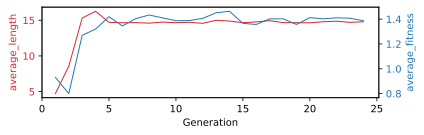

AUC:    	86
Precision: 	84
Recall: 	89
Acc (-):    	88


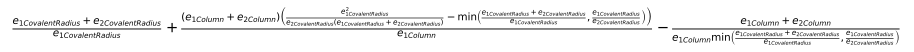

In [167]:
examine_model(sh.best_estimator_)

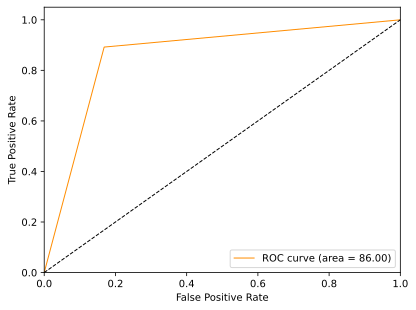

In [168]:
### Plot ROC
fpr, tpr, _ = roc_curve(labels_test,predictions)
plt.figure()
plt.plot( fpr, tpr, color="darkorange", 
         label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [116]:
# ### Train a single sym learner
# SR_classifier = SymbolicClassifier(population_size = 500, 
#                                    generations=100,
#                                    tournament_size = 50,
#                                    init_depth=(1,5),
#                                    parsimony_coefficient=0.005,
#                                    p_crossover = 0.85,
#                                    p_subtree_mutation = 0.01,
#                                    p_point_mutation = 0.01,
#                                    p_hoist_mutation = 0.1,
#                                    const_range=(-10,10),
#                                    feature_names=feature_names,
#                                    n_jobs=-1, 
# #                                    verbose=1,
#                                    random_state=1,
#                                    function_set={'add','sub','mul','div','max','min'}
#                                   )

# SR_classifier.fit(features_train, labels_train)

SymbolicClassifier(const_range=(-10, 10),
                   feature_names=Index(['e1_CovalentRadius/e2_CovalentRadius',
       '(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius',
       '(e1_Column+e2_Column)/e1_Column'],
      dtype='object'),
                   function_set={'mul', 'add', 'min', 'sub', 'max', 'div'},
                   generations=100, init_depth=(1, 5), n_jobs=-1,
                   p_crossover=0.85, p_hoist_mutation=0.1,
                   parsimony_coefficient=0.005, population_size=500,
                   random_state=1, tournament_size=10)

In [ ]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict_proba(remainder_negative_features)[:,1]

estimated_classes[:20]